In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch_geometric_temporal.signal import temporal_signal_split
from torch_geometric_temporal.dataset import WikiMathsDatasetLoader
from torch_geometric_temporal.nn.recurrent import EvolveGCNH
from tqdm import tqdm

In [2]:
dataset = WikiMathsDatasetLoader().get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.5)

In [3]:
train_dataset

In [4]:
mean_cases = [snapshot.y.mean().item() for snapshot in dataset]
std_cases = [snapshot.y.std().item() for snapshot in dataset]

In [5]:
df = pd.DataFrame(mean_cases, columns=['mean'])
df['std'] = pd.DataFrame(std_cases, columns=['std'])
df

,mean,std
0,-0.393381,0.520698
1,0.734658,0.876654
2,0.809123,0.830659
3,0.835980,1.097929
4,0.733515,0.802907
...,...,...
718,0.811049,0.853534
719,0.423197,0.648330
720,-0.251592,0.958488
721,-0.029317,1.011687


In [6]:
df['rolling'] = df['mean'].rolling(7).mean()
df

,mean,std,rolling
0,-0.393381,0.520698,NaN
1,0.734658,0.876654,NaN
2,0.809123,0.830659,NaN
3,0.835980,1.097929,NaN
4,0.733515,0.802907,NaN
...,...,...,...
718,0.811049,0.853534,0.521658
719,0.423197,0.648330,0.505378
720,-0.251592,0.958488,0.506229
721,-0.029317,1.011687,0.513233


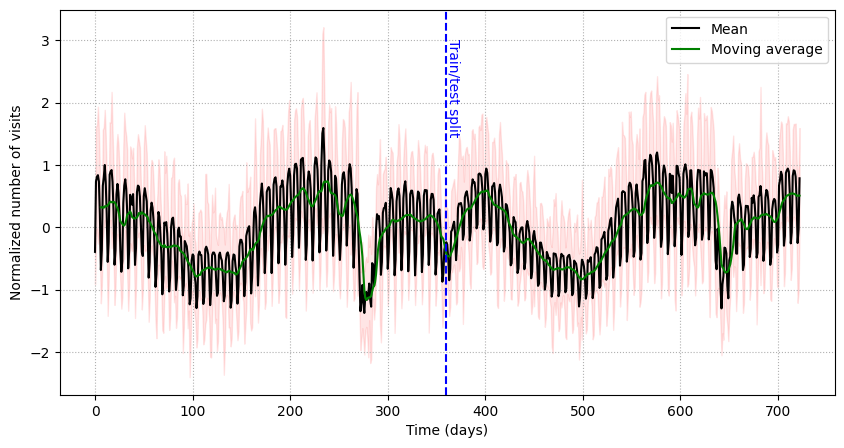

In [7]:
plt.figure(figsize=(10,5))
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')

In [8]:
dataset[0]

Data(x=[1068, 8], edge_index=[2, 27079], edge_attr=[27079], y=[1068])

In [9]:
dataset[0].y

tensor([-0.4067, -0.1620, -0.4043,  ..., -0.9163, -1.0110, -0.5007])

In [10]:
dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 1056, 1063, 1065],
        [   1,    2,    3,  ..., 1059, 1064, 1066]])

In [11]:
dataset[0].edge_attr

tensor([1., 4., 2.,  ..., 1., 1., 2.])

In [12]:
dataset[0].x[0]

tensor([-0.4323, -0.4739,  0.2659,  0.4844,  0.5367,  0.6412,  0.2179, -0.7617])

In [13]:
dataset[1]

Data(x=[1068, 8], edge_index=[2, 27079], edge_attr=[27079], y=[1068])

In [14]:
dataset[1].x[0]

tensor([-0.4739,  0.2659,  0.4844,  0.5367,  0.6412,  0.2179, -0.7617, -0.4067])

In [15]:
dataset[1].edge_attr

tensor([1., 4., 2.,  ..., 1., 1., 2.])

In [16]:
dataset[1].y

tensor([0.3064, 0.3470, 0.7482,  ..., 2.2502, 1.8601, 0.1492])

In [17]:
dataset[2]

Data(x=[1068, 8], edge_index=[2, 27079], edge_attr=[27079], y=[1068])

In [18]:
dataset[2].x[0]

tensor([ 0.2659,  0.4844,  0.5367,  0.6412,  0.2179, -0.7617, -0.4067,  0.3064])

In [19]:
dataset[2].y

tensor([0.4972, 0.5457, 0.6305,  ..., 0.8699, 0.2451, 0.0200])

In [20]:
dataset[2].edge_attr

tensor([1., 4., 2.,  ..., 1., 1., 2.])

In [21]:
torch.manual_seed(0)

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_count, dim_in):
        super().__init__()
        self.recurrent = EvolveGCNH(node_count, dim_in)
        self.linear = torch.nn.Linear(dim_in, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(dataset[0].x.shape[0], dataset[0].x.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()


TemporalGNN(
  (recurrent): EvolveGCNH(
    (pooling_layer): TopKPooling(8, ratio=0.00749063670411985, multiplier=1.0)
    (recurrent_layer): GRU(8, 8)
    (conv_layer): GCNConv_Fixed_W(8, 8)
  )
  (linear): Linear(in_features=8, out_features=1, bias=True)
)

In [22]:
# Training
for epoch in tqdm(range(50)):
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        loss = torch.mean((y_pred-snapshot.y)**2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Evaluation
model.eval()
loss = 0
for i, snapshot in enumerate(test_dataset):
    y_pred = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    mse = torch.mean((y_pred-snapshot.y)**2)
    loss += mse
loss = loss / (i+1)
print(f'MSE = {loss.item():.4f}')

100%|██████████| 50/50 [01:25<00:00,  1.71s/it]


MSE = 0.7649


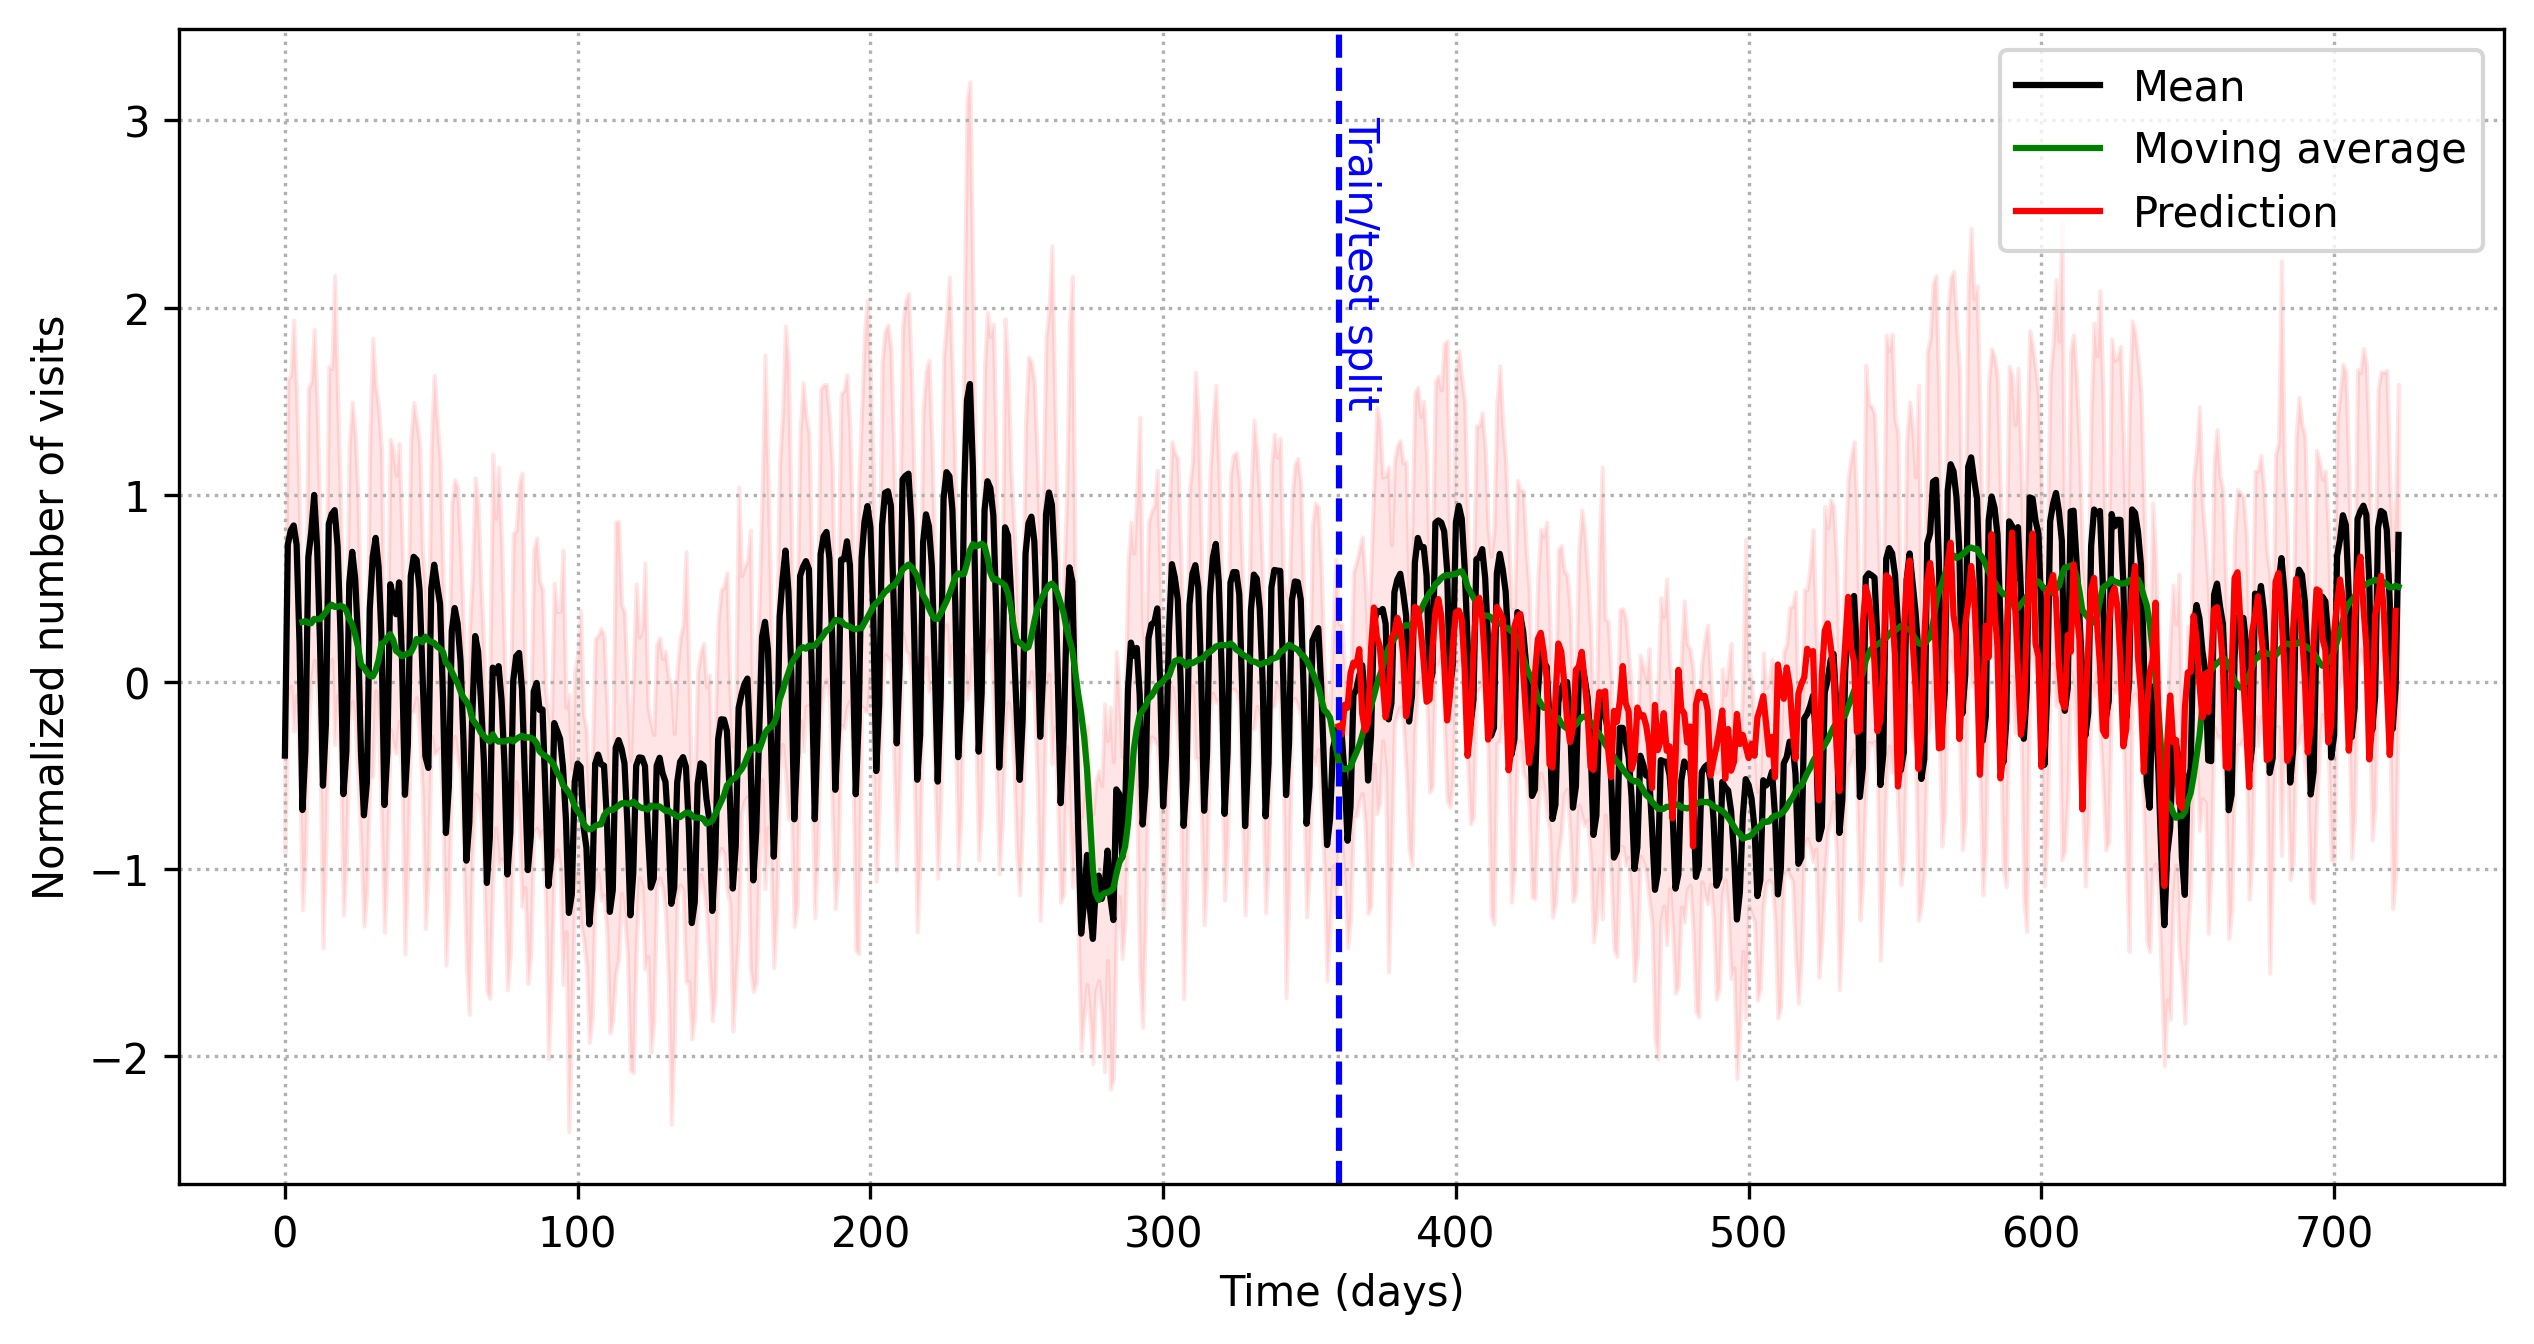

In [23]:
y_preds = [model(snapshot.x, snapshot.edge_index, snapshot.edge_attr).squeeze().detach().numpy().mean() for snapshot in test_dataset]

plt.figure(figsize=(10,5), dpi=300)
plt.plot(df['mean'], 'k-', label='Mean')
plt.plot(df['rolling'], 'g-', label='Moving average')
plt.plot(range(360,722), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(df.index, df['mean']-df['std'], df['mean']+df['std'], color='r', alpha=0.1)
plt.axvline(x=360, color='b', linestyle='--')
plt.text(360, 1.5, 'Train/test split', rotation=-90, color='b')
plt.xlabel('Time (days)')
plt.ylabel('Normalized number of visits')
plt.legend(loc='upper right')